In [182]:
#import user modules
import helper_functions as hfun
import config as cf
import thouless_times as thouless
import plot_spectrals as spec_fun
import adiabatics as agp
import importlib
importlib.reload(hfun)
importlib.reload(cf)
importlib.reload(thouless)

#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym
from scipy.optimize import curve_fit as fit

print(cf.base_directory)


user_settings = getattr(cf.plot_settings, 'settings')

../results/Heisenberg/disorder/PBC/


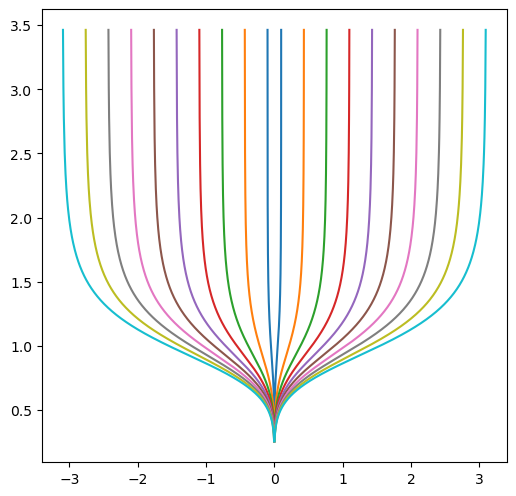

In [183]:
a = 1.2
b = 2 - a
fig, ax = plt.subplots(figsize=(6,6), dpi = 100)

Wlist = np.linspace(0.1, 3.1, 10)
for W in Wlist:
    def distribution(h):
        return np.abs(h)**(a-1.) * (W - np.abs(h))**(b-1)
    
    h = np.linspace(-W, W, 1000)
    ax.plot(h, distribution(h))




In [ ]:
import sympy as sm
from scipy.stats import halfnorm

W = sm.Symbol('W', positive=True)
#a = sm.Symbol('a', positive=True)
a = 3.1
b = 2.0
f = W**(a - 1.0) * (1.0 - W)**(b - 1.0)
#f = (sm.sqrt(2/sm.pi) * sm.exp(-(W/a)/2))/a

mean = sm.integrate(W*f, (W, 0, sm.oo))
var = sm.integrate(((W-mean)**2)*f, (W, 0, sm.oo))

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,4), dpi = 100)
axis.annotate(r"$\mu=" + sm.latex(mean) + "$" + f"\n\n" + r"$\sigma=" + sm.latex(var) + "$", xy=(0.5, 0.5), color='black', size=24, ha='center', va='center')

#f.subs(a, 2)
p1 = sm.plotting.plot(f, (W, -1, 1), show=True)



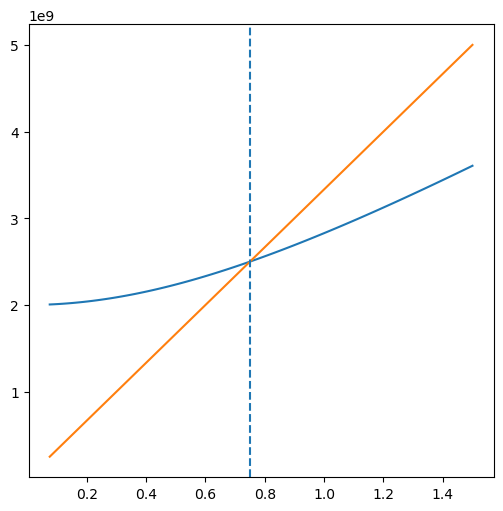

In [279]:
const=25
W_crit = np.sqrt(9.0 / (const - 9.0))
def width(M, W):
    return np.sqrt( (M**2) / const * (W**2 + 1)  )

def bubble_increase(M, W):
    return (M + 1.) / 3. * W

W = np.linspace(0.1*W_crit, 2*W_crit, 100)

fig, ax = plt.subplots(figsize=(6,6), dpi = 100)

M = 1e10
ax.plot(W, width(M, W))
ax.plot(W, bubble_increase(M, W))
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.axvline(x=W_crit, linestyle='--')

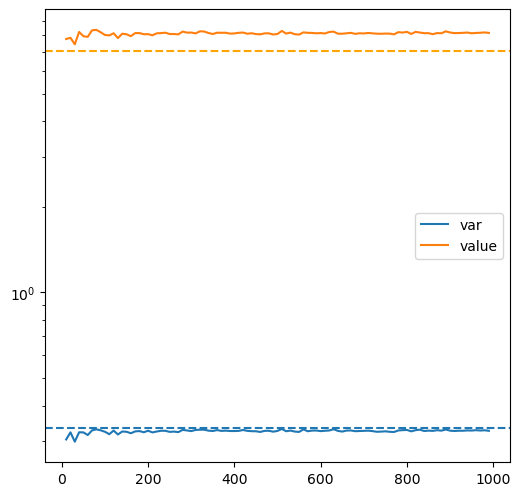

In [269]:
realis = 1000
var = []
value = []
L = 50
fig, ax = plt.subplots(figsize=(6,6), dpi = 100)
for r in range(10, realis, 10):
    var_tmp = 0
    tmp = 0
    for ooo in range(1, r):
        epsilon = np.random.uniform(-1.0, 1.0, L)
        var_tmp = var_tmp + np.var(epsilon)
        for i in range(1, len(epsilon)):
            tmp = tmp + epsilon[i]**2 * i
    value.append(tmp / r / L)
    var.append(var_tmp / r)
ax.plot(range(10, realis, 10), np.abs(var), label = 'var')
ax.plot(range(10, realis, 10), np.abs(value), label = 'value')
ax.axhline(y=1./3., linestyle='--')
ax.axhline(y=np.sqrt(L), linestyle='--',color='orange')
ax.set_yscale('log')
ax.legend()